In [515]:
using PyPlot, LsqFit, Polynomials, Random, Statistics
using CurveFit

# Numerical many-body methods - Problem Set 4 
## (Classical Monte Carlo)
Noam Ophir

# 2D XY model and the Kosterlitz-Thouless transition

*In this exercise we will consider the 2D XY model on a square lattice. Consider a spin of unit length pointing within the $x-y$ plane at each site of the lattice, and denote by $\theta_i$ the direction of the spin on site $i$. The energy of the system is given by*

$$H=-J\sum_{\langle i,j\rangle} \cos(\theta_i-\theta_j)$$

*where the summation $\langle i,j\rangle$ is over nearest neighbors on the lattice. We will assume $J > 0$.*

*Since in 2D a continuous symmetry can not be spontaneously broken at finite temperature (due to Mermin-Wagner theorem) there is no conventional ordering phase transition as the temperature is lowered. However, the model does exhibit a transition from a fully disordered phase at high temperatures (in which spin correlations decay exponentially) to a quasi-ordered state at low temperatures (in which the decay of spin correlations obeys a power law). This transition is known as the Kosterlitz-Thouless transition, and can be understood in terms of proliferation of vortices at high temperatures: in the low temperature phase vortices are bound into vortex-antivortex pairs, while at high temperatures the vortices and antivortices become free. The transition between these two phases occurs at a temperature $T_{KT}$ that you will determine in this exercise.*

*We'll start with generalizing the Wolf algorithm we discussed for the Ising model to the case of spins that can point in an arbitrary direction in an $N$-dim space, i.e. $\vec{S}_i\in O(N)$. (For the XY case we have $N = 2$.) This is done by considering a projection of all the spins in the system onto a random direction and then using the Ising cluster algorithm for this projected state. Denoting the random direction by $\hat{e}$, two spins $\vec{S}_i,\;\vec{S}_j$ are now connected with probability*

$$p=1-e^{\mathrm{min}(0,-2\beta J (\vec{S}_i\cdot \hat{e})(\vec{S}_j\cdot \hat{e})}\;.$$

*Note that here $\vec{S}_i\cdot \hat{e}$ is simply the component of $\vec{S}_i$ along the direction $\hat{e}$. If these components are anti-aligned for the two spins $i,j$, then these two spins will never be connected (similarly to anti-aligned spins in the Ising case). In the Wolf algorithm a cluster is then constructed similarly to the Ising case starting from a random spin on the lattice. The update is done by flipping the projections of the spins in the cluster onto the direction $\hat{e}$, i.e. $\vec{S}_i\mapsto \vec{S}_i - 2(\vec{S}_i\cdot \hat{e})\hat{e}$.*

## 1
*Implement the Monte Carlo algorithm using Wolf cluster updates for the XY model in 2D.*

In [57]:
### Tutorial functions
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In [334]:
function XYConfigurationEnergy(lat::SquareLattice, config::Vector{Float64})
    
    N = length(lat)
    @assert N == length(config) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec +=  -sum(cos.(config[j] .- config[nn]))
    end
    return Ec/2 # in the summation above every bond is included twice
end

function NNDelta(lat::SquareLattice, config::Vector{Float64})
    
    N = length(lat)
    @assert N == length(config) "Configuration incompatible with lattice size"
    
    Delta = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Delta +=  sum(abs.(config[j] .- config[nn]))
    end
    return Delta/(2*4*N)
end

function CalculateError(m, Neq, Nsw)
    # Function to calculate the error in the mean magnetization using binning analysis
    
    err = Float64[]

    # Determine the number of sweeps for error analysis
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than the number of sweeps after equilibration

    # Extract the last Nsw2 magnetization values for error analysis
    ml = m[end-Nsw2+1:end]

    # Set the minimum size for the moving block (binning) analysis
    min_size = 2^5

    # Perform the moving block (binning) analysis
    while length(ml) > min_size
        # Compute the standard error of the mean and append to the error array
        push!(err, std(ml) / sqrt(length(ml) - 1))

        # Reduce the size of the data by taking the mean of consecutive pairs (binning)
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1, stop=div(length(ml),2)))
    end

    return err
end

CalculateError (generic function with 1 method)

In [340]:
function XYWolffUpdate!(lat::SquareLattice, config::Vector{Float64}, T::Float64)
    # Get the lattice size
    N = length(lat)
    
    # Check if the configuration size matches the lattice size
    @assert N == length(config) "Configuration incompatible with lattice size"
    
    # Pick a random site
    ind = rand(1:N)

    theta0 = rand()*2*pi
    
    # Arrays to store cluster indices and newly added neighbors
    cluster = Int64[] 
    newlyAdded = Int64[] 
    
    # Add the selected site to the cluster and its neighbors to newlyAdded
    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    # Perform the Wolff algorithm until the cluster is empty
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        
        # Skip if already in the cluster
        if j in cluster
            continue
        end
        
        # If random number is less than p, add to cluster
        if rand() < (1. - exp(min(0,-2 * cos(config[j] - theta0) * cos(config[ind]- theta0)/ T)))
            push!(cluster, j)
            
            # Add neighbors of the current site to newlyAdded
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end
    
    # flipping the projections of the spins in the cluster onto the direction x
    config[cluster] .= ( 2*theta0 + pi .- config[cluster]) .% (2*pi)
end

function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64; saveConfigs = false)
    """
    Perform XY model Monte Carlo simulations using Wolf algorithm.

    Parameters:
    `lat`: SquareLattice object representing the lattice.
    `T`: Temperature.
    `Nsw`: Number of sweeps to perform.
    `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    `saveConfigs`: Save configurations at each sweep if true.
    """
    config = rand(length(lat))*2*pi  # Initialize random spin configuration.

    if saveConfigs
function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64; saveConfigs = false)
    """
    Perform XY model Monte Carlo simulations using Wolf algorithm.

    Parameters:
    `lat`: SquareLattice object representing the lattice.
    `T`: Temperature.
    `Nsw`: Number of sweeps to perform.
    `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    `saveConfigs`: Save configurations at each sweep if true.
    """
    config = rand(length(lat))*2*pi  # Initialize random spin configuration.

    if saveConfigs
function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64; saveConfigs = false)
    """
    Perform XY model Monte Carlo simulations using Wolf algorithm.

    Parameters:
    `lat`: SquareLattice object representing the lattice.
    `T`: Temperature.
    `Nsw`: Number of sweeps to perform.
    `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    `saveConfigs`: Save configurations at each sweep if true.
    """
    config = rand(length(lat))*2*pi  # Initialize random spin configuration.

    if saveConfigs
        configs = zeros(Int64, Nsw, length(lat))  # Matrix to store configurations at each sweep.
        configs[1, :] = config  # Save initial configuration.
    end

    En = zeros(Float64, Nsw)  # Array to store energy at each sweep.
    En[1] = XYConfigurationEnergy(lat, config)  # Initial energy.
    
    for i in range(2, stop=Nsw)  # Loop over sweeps.
        
        XYWolffUpdate!(lat, config, T)  # Perform cluster update.
        En[i] = XYConfigurationEnergy(lat, config)  # Calculate new energy.

        
        if saveConfigs
            configs[i, :] = config  # Save current configuration.
        end


    end
    if saveConfigs
        return  En, configs
    else
        return En, config
    end
    
end

XY_MC (generic function with 2 methods)

## 2
*Check autocorrelation and equilibration times for systems up to $32\times32$ sites in the low temperature regime (e.g. $T=0.1$), close to the phase trasition (e.g. $T=1$), and in the high temperature regime (e.g. $1.5$). Plot sample configurations at each temperature and check whether they agree qualitatively with what you would expect. (If you are using PyPlot you can use `imshow` to plot a 2D image corresponding to the configuration. Tip: use a cyclic `colormap` such as `"hsv"` so that  $\theta=0$ and $\theta=2\pi$ are shown with the same color.)*

In [351]:
lat = SquareLattice(32,32)
Ts = [0.1,1,1.5]
Nsw = 100000
E = []
configs = []
for T in Ts
    @time En, config = XY_MC(lat, T, Nsw);
    append!(E,[En])
    append!(configs,[config])
end


120.380816 seconds (701.02 M allocations: 68.747 GiB, 5.82% gc time)


 65.163540 seconds (647.44 M allocations: 59.222 GiB, 9.87% gc time)


 41.654884 seconds (616.17 M allocations: 55.121 GiB, 14.85% gc time)


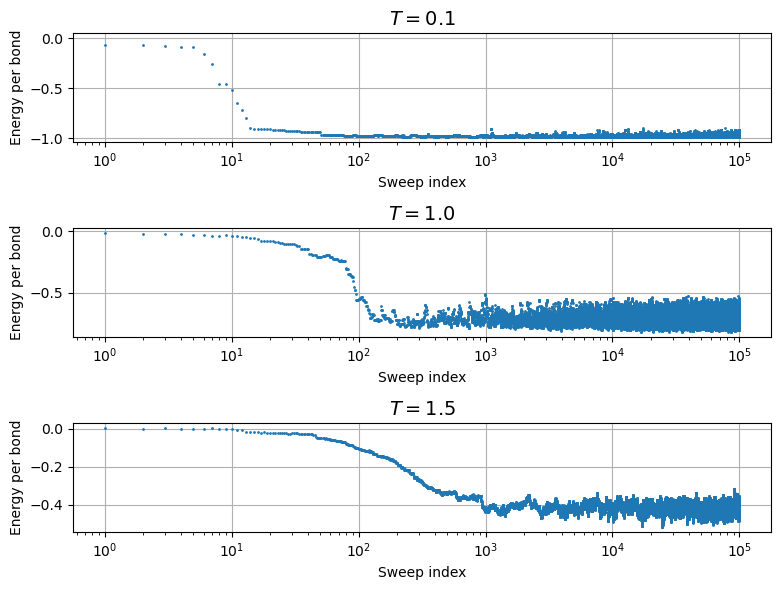

In [355]:
fig,ax = subplots(3,1,figsize=(8,6))
for i = 1:3
    ax[i].plot(E[i] ./ length(lat)/2,".",markersize=2)
    ax[i].set_xlabel("Sweep index")
    ax[i].set_ylabel("Energy per bond")
    ax[i].grid()
    ax[i].set_title(L"$T=$"*string(Ts[i]), fontsize=14)
    ax[i].set_xscale("log")
end
fig.tight_layout() 

gcf()


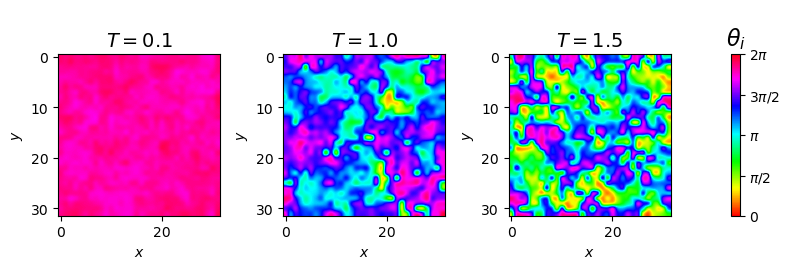

In [356]:
fig,ax = subplots(1,4,figsize=(8,3),gridspec_kw=Dict("width_ratios" => [3,3,3,0.1]))
for i = 1:3
    lattice_config = zeros(32,32)
    for index in range(1,length(configs[i]))
        p = IndexToPoint(lat,index)
        lattice_config[p.x,p.y] = configs[i][index]
    end
    global im1 = ax[i].imshow(lattice_config, vmax= 2*pi, vmin=0,
                cmap="hsv", interpolation="gaussian")
    ax[i].set_xlabel(L"$x$")
    ax[i].set_ylabel(L"$y$")
    ax[i].set_title(L"$T=$"*string(Ts[i]), fontsize=14)
end
ax[4].set_axis_off()
cbar = colorbar(im1, ax=ax[end], fraction=1.5, pad=0.8)
cbar.ax.set_title(L"$\theta_i$", fontsize=16)
cbar.set_ticks(0:pi/2:2*pi)
cbar.set_ticklabels([L"$0$",L"$\pi/2$",L"$\pi$",L"$3\pi/2$",L"$2\pi$"])

fig.tight_layout() 

gcf()

Autocorrelation time: 23.0
Autocorrelation time: 11.0
Autocorrelation time: 126.0


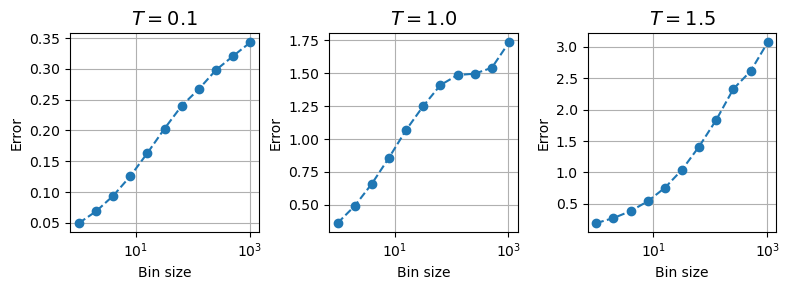

In [357]:
Neq = 2000

fig,ax = subplots(1,3,figsize=(8,3))

for i = 1:3
    err = CalculateError(E[i], Neq, Nsw)
    ax[i].plot(2 .^ range(0, length= length(err)), err, "--o")
    ax[i].set_xlabel("Bin size")
    ax[i].set_ylabel("Error")
    ax[i].grid()
    ax[i].set_title(L"$T=$"*string(Ts[i]), fontsize=14)
    ax[i].set_xscale("log")
    println("Autocorrelation time: ", round(((err[end]/err[1])^2-1)/2) )
end
fig.tight_layout() 

gcf()

## 3

*Calculate the spin-spin correlation function $C(|i-j|)=\langle \cos(\theta_i-\theta_j) \rangle$ (for simplicity you can calculate the correlations along the $x$- and/or $y$-directions, or consider their average) for a system of size $32\times32$. Show that at low temperatures the correlations obey a power law (what is the exponent as $T \rightarrow 0$?), while at high temperatures the decay is exponential.*

In [423]:
function XY_correlations(lat::SquareLattice, config::Vector{Float64})
    N = length(lat)
    @assert N == length(config) "Configuration incompatible with lattice size"
        
    corr = zeros(Int(sqrt(N)))
    for i = 1:Int(sqrt(N))
        for j = i:Int(sqrt(N))
            index = PointToIndex(lat, Point2D(i,j))
                for x = 1:Int(sqrt(N))
                    index_p = PointToIndex(lat,Point2D(mod1(i+x,Int(sqrt(N))),j))
                    corr[x] += cos(config[index]-config[index_p])
                end
        end
    end
    return corr ./ sqrt(N)
end

XY_correlations(lat,configs[3])

function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64)

    config = rand(length(lat))*2*pi  # Initialize random spin configuration.
    
    corr = []

    append!(corr,[XY_correlations(lat,config)])

    for i in range(2, stop=Nsw)  # Loop over sweeps.      
        XYWolffUpdate!(lat, config, T)  # Perform cluster update.
        append!(corr,[XY_correlations(lat,config)])
    end

    return corr, config
end

XY_MC (generic function with 2 methods)

In [495]:
Ts = 0.1:0.3:2.1
Nwep = 20000
Neq  = 2000
corrs = []
for T in Ts
    @time corr, config = XY_MC(lat,T,Nwep)
    append!(corrs,[mean(corr[Neq:Nwep])])
end

 21.489130 seconds (17.41 M allocations: 2.782 GiB, 1.65% gc time)


 18.084652 seconds (13.48 M allocations: 1.972 GiB, 1.37% gc time)


 15.260538 seconds (10.42 M allocations: 1.414 GiB, 1.16% gc time)


 12.299806 seconds (6.54 M allocations: 875.178 MiB, 0.90% gc time)


  8.515313 seconds (1.46 M allocations: 187.364 MiB, 0.43% gc time)


  8.434597 seconds (331.96 k allocations: 42.152 MiB)


  8.469685 seconds (248.91 k allocations: 31.504 MiB, 0.19% gc time)


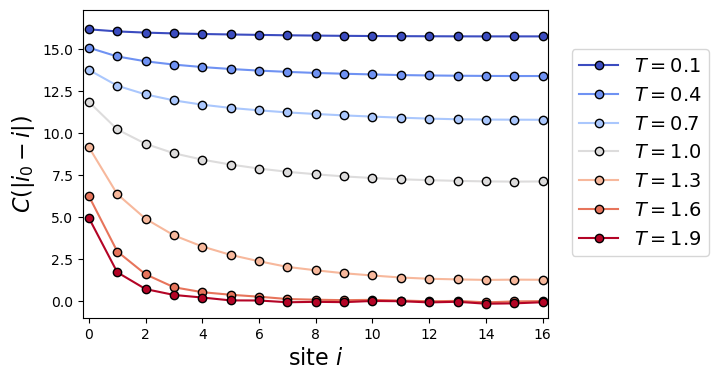

In [505]:
fig,ax=subplots(figsize=(6,4))
cmap = get_cmap("coolwarm")

# ax.plot(corrs[1],"-o")
for i = 1:length(Ts)
    color_index = (i-1) / (length(Ts)-1)
    plot(corrs[i], color=cmap(color_index),markeredgecolor="black","-o"
            , label=L"$T=$"*string(round(Ts[i],digits=3)))
end

ax.legend(loc=(1.05,0.2),fontsize=14)
ax.set_xlim([-0.2,16.2])
ax.set_xlabel(L"site $i$", fontsize=16)
ax.set_ylabel(L"$C(|i_0-i|)$", fontsize=16)
gcf()

In [544]:
Ts = 0.01:0.04:0.3
Nwep = 20000
Neq  = 2000
corrs = []
for T in Ts
    @time corr, config = XY_MC(lat,T,Nwep)
    append!(corrs,[mean(corr[Neq:Nwep])])
end

 23.749755 seconds (19.71 M allocations: 3.232 GiB, 1.76% gc time)


 22.333005 seconds (18.40 M allocations: 2.977 GiB, 1.66% gc time)


 23.288815 seconds (17.54 M allocations: 2.812 GiB, 1.68% gc time)


 21.232076 seconds (16.87 M allocations: 2.677 GiB, 1.68% gc time)


 19.791180 seconds (16.33 M allocations: 2.568 GiB, 1.67% gc time)


 20.239774 seconds (15.69 M allocations: 2.442 GiB, 1.64% gc time)


 18.311330 seconds (15.37 M allocations: 2.373 GiB, 1.66% gc time)


 18.424713 seconds (14.79 M allocations: 2.257 GiB, 1.62% gc time)


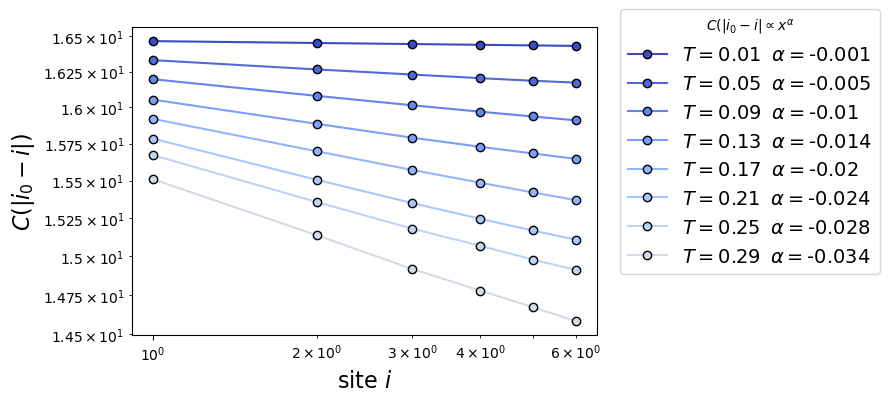

In [558]:
fig,ax=subplots(figsize=(6,4))

alpha =[]
for i = 1:length(Ts)
    color_index = (i-1) / (2*length(Ts)-1)
    p = CurveFit.curve_fit(LinearFit, log.(1:1:6), log.(corrs[i][1:6]))
    append!(alpha, p.coefs[2])
    plot(1:1:6,corrs[i][1:6], color=cmap(color_index),markeredgecolor="black","-o"
            , label=L"$T=$"*string(round(Ts[i],digits=3))*
            L"$\;\; \alpha=$"*string(round(p.coefs[2],digits=3)))
end

ax.legend(loc=(1.05,0.2),fontsize=14,title=L"$C(|i_0-i|\propto x^\alpha$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"site $i$", fontsize=16)
ax.set_ylabel(L"$C(|i_0-i|)$", fontsize=16)
gcf()

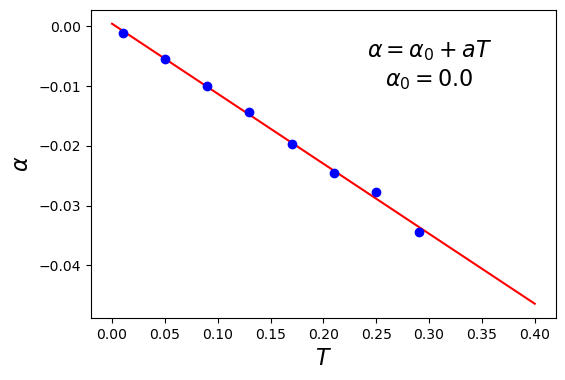

In [572]:
fig,ax=subplots(figsize=(6,4))

ax.scatter(Ts,alpha,color="blue")
Ts_float64 = convert(Vector{Float64}, Ts)
alpha_float64 = convert(Vector{Float64}, alpha)

p = CurveFit.curve_fit(LinearFit, Ts_float64, alpha_float64)


ts = 0:0.01:0.4
ax.plot(ts, p.coefs[1] .+ p.coefs[2] .* ts, color="red",zorder=0)
ax.text(0.3,-0.01,L"$\alpha=\alpha_0 + a T$"*"\n"*L"$\alpha_0=$"*string(round(p.coefs[1],digits=3))
        ,fontsize=16, horizontalalignment = "center")
# ax.legend(loc=(1.05,0.2),fontsize=14,title=L"$C(|i_0-i|\propto x^\alpha$")
ax.set_xlabel(L"$T$", fontsize=16)
ax.set_ylabel(L"$\alpha$", fontsize=16)
gcf()

In [579]:
Ts = 1.5:0.2:2.5
Nwep = 100000
Neq  = 5000
corrs = []
for T in Ts
    @time corr, config = XY_MC(lat,T,Nwep)
    append!(corrs,[mean(corr[Neq:Nwep])])
end

 41.836715 seconds (2.07 M allocations: 264.446 MiB, 0.71% gc time)


 41.397895 seconds (1.46 M allocations: 185.109 MiB, 0.08% gc time)


 42.373059 seconds (1.27 M allocations: 160.497 MiB, 0.05% gc time)


 42.257828 seconds (1.16 M allocations: 147.678 MiB, 0.06% gc time)


 41.983275 seconds (1.11 M allocations: 140.634 MiB, 0.07% gc time)


 42.066669 seconds (1.07 M allocations: 135.604 MiB, 0.07% gc time)


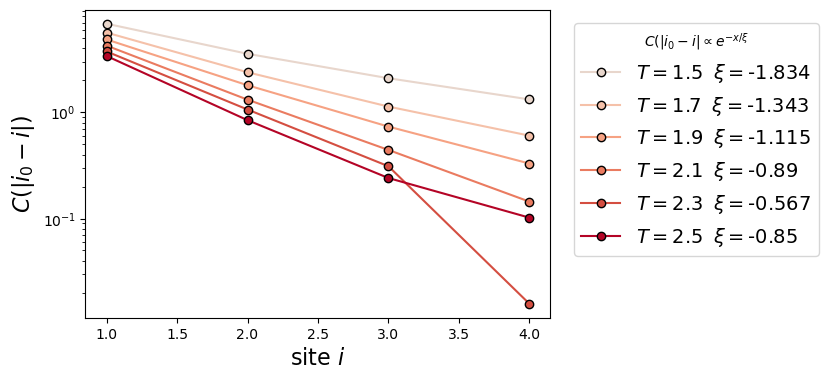

In [593]:
fig,ax=subplots(figsize=(6,4))

alpha =[]
for i = 1:length(Ts)
    color_index = (length(Ts)+i-1) / (2*length(Ts)-1)
    p = CurveFit.curve_fit(LinearFit, convert(Vector{Float64},1:1:4), log.(corrs[i][1:4]))
    plot(1:1:4,corrs[i][1:4], color=cmap(color_index),markeredgecolor="black","-o"
            , label=L"$T=$"*string(round(Ts[i],digits=3))*
            L"$\;\; \xi=$"*string(round(1/p.coefs[2],digits=3)))
end

ax.legend(loc=(1.05,0.2),fontsize=14,title=L"$C(|i_0-i|\propto e^{-x/\xi}$")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"site $i$", fontsize=16)
ax.set_ylabel(L"$C(|i_0-i|)$", fontsize=16)
gcf()

*An important characteristic of the KT transition is a discontinuity in the spin stiffness at the point of the transition. (The discontinuity will of course occur only in the thermodynamic limit and will be smoothed for  nite systems.)*

*Spin stiffness, $\rho_s$, is a quantity that characterizes the tendency of ordered spins to adapt in response to perturbations imposing modulations of the direction of the order parameter. When spins are ordered (or quasi-ordered as in the XY 2D case) $\rho_s$ is finite, while in the disordered phase $\rho_s=0$. The spin stiffness is defined as*

$$\rho_s=\frac{1}{N}\frac{\partial^2 F}{\partial \phi^2}=-\frac{1}{2N}\left( \langle E \rangle +\frac{1}{T} \Big( \left< I_x^2\right>^2+\left< I_y^2\right>^2 \Big)\right)$$

*where $F(\phi)$ is the free energy in presence of a twist field that imposes a twist $\phi$ on the spins, $N$ is the total number of spins in the system and $I_{a=x,y}$ are spin currents along the $a = x, y$ direction, defined as*

$$I_a = \sum_{\left<i,j\right>_a} \sin(\theta_i-\theta_j)$$
*where $\left<i,j\right>_a$ denotes nearest neighbors along $a = x, y$. (See Sandvik's review Chapter 3.5 for more details.)*

## 4
*Calculate the spin stiffness as a function of temperature, in a temperature range between $T=0.1$ and $T=2.0$, for system sizes $L = 4, 8, 16$ (where $L$ is the linear systems size, i.e. the total number of sites is $N = L^2$). Check that at $T \rightarrow 0$, $\rho_S \rightarrow1$, and that at large $T$, $\rho_S \rightarrow0$. You should be able to see that the drop in the spin stiffness is becoming more abrupt with increasing $L$ (i.e. as we are approaching the thermodynamic limit).*

In [595]:
function IxIy(lat::SquareLattice, config::Vector{Float64})
    """
    Returns the I_x, I_y
    """
    N = length(lat)
    @assert N == length(config) "Configuration incompatible with lattice size"

    Ix = 0
    Iy = 0

    L = Int(sqrt(N))
    
    for i = 1:L
        for j = 1:L
            index = PointToIndex(lat, Point2D(i,j))
            ii = mod1(i+1, L)
            jj = mod1(j+1, L)

            Ix += sin(config[index]-config[PointToIndex(lat, Point2D(ii,j))])
            Iy += sin(config[index]-config[PointToIndex(lat, Point2D(i,jj))])
        end
    end
    
    return Ix, Iy
end

IxIy (generic function with 1 method)

In [597]:
function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64; Neq = Int(1e3))

    config = rand(length(lat))*2*pi  # Initialize random spin configuration.
    
    En = zeros(Nsw-Neq)
    Ix = zeros(Nsw-Neq)
    Iy = zeros(Nsw-Neq)

    append!(corr,[XY_correlations(lat,config)])

    for i in range(2, stop=Nsw)  # Loop over sweeps.      
        XYWolffUpdate!(lat, config, T)  # Perform cluster update.
        if i > Neq
            En[i] = XYConfigurationEnergy(lat, config)
            Ix[i], Iy[i] = IxIy(lat, config)
        end
    end


    return mean(En), mean(Ix .^2), mean(Iy .^2), config
end

XY_MC (generic function with 2 methods)

In [606]:
Ns = [4^2,8^2,16^2]
Ts = 0.1:0.1:2.0

rhos = zeros(length(Ns),length(Ts))
Nsw = Int(1e5)

for i = 1:length(Ns)
    L = Int(sqrt(Ns[i]))
    lat = SquareLattice(L,L)
    for j = 1:length(Ts)
        @time En, Ix2, Iy2, config = XY_MC(lat, Ts[j], Nsw)
        rhos[i,j] = - (En + (Ix2 + Iy2)/Ts[j])/(2*Ns[i])
    end
end

  0.804717 seconds (7.39 M allocations: 772.841 MiB, 17.86% gc time)


  0.955621 seconds (7.28 M allocations: 738.957 MiB, 32.19% gc time)


  0.848775 seconds (7.19 M allocations: 711.340 MiB, 23.38% gc time)


  0.719844 seconds (7.11 M allocations: 683.651 MiB, 10.58% gc time)


  0.754425 seconds (7.04 M allocations: 661.142 MiB, 10.74% gc time)


  0.796087 seconds (6.96 M allocations: 643.179 MiB, 11.01% gc time)


  0.812654 seconds (6.90 M allocations: 629.316 MiB, 12.98% gc time)


  0.757546 seconds (6.83 M allocations: 619.018 MiB, 10.47% gc time)


  0.733162 seconds (6.77 M allocations: 610.254 MiB, 10.74% gc time)


  0.729574 seconds (6.69 M allocations: 600.113 MiB, 12.80% gc time)


  0.720026 seconds (6.62 M allocations: 590.802 MiB, 11.50% gc time)


  0.690168 seconds (6.54 M allocations: 581.036 MiB, 9.90% gc time)


  0.695886 seconds (6.47 M allocations: 572.089 MiB, 12.42% gc time)


  0.704344 seconds (6.40 M allocations: 562.336 MiB, 10.70% gc time)


  0.692564 seconds (6.34 M allocations: 554.215 MiB, 13.00% gc time)


  1.017504 seconds (6.28 M allocations: 546.597 MiB, 10.02% gc time)


  0.725995 seconds (6.22 M allocations: 539.264 MiB, 14.29% gc time)


  0.660692 seconds (6.18 M allocations: 533.810 MiB, 13.53% gc time)


  0.664763 seconds (6.14 M allocations: 528.520 MiB, 14.12% gc time)


  0.650668 seconds (6.11 M allocations: 523.931 MiB, 13.39% gc time)


  2.982093 seconds (25.87 M allocations: 2.890 GiB, 11.96% gc time)


  3.244756 seconds (25.42 M allocations: 2.730 GiB, 12.89% gc time)


  2.998778 seconds (25.07 M allocations: 2.587 GiB, 11.81% gc time)


  2.939693 seconds (24.73 M allocations: 2.463 GiB, 11.80% gc time)


  2.908598 seconds (24.44 M allocations: 2.384 GiB, 11.74% gc time)


  2.834366 seconds (24.17 M allocations: 2.336 GiB, 12.20% gc time)


  3.015955 seconds (23.86 M allocations: 2.291 GiB, 13.31% gc time)


  2.678526 seconds (23.53 M allocations: 2.243 GiB, 11.78% gc time)


  2.610221 seconds (23.20 M allocations: 2.196 GiB, 11.61% gc time)


  2.556797 seconds (22.84 M allocations: 2.143 GiB, 11.95% gc time)


  2.480914 seconds (22.43 M allocations: 2.081 GiB, 12.58% gc time)


  2.352416 seconds (22.03 M allocations: 2.019 GiB, 12.17% gc time)


  2.266034 seconds (21.59 M allocations: 1.952 GiB, 12.99% gc time)


  2.169716 seconds (21.26 M allocations: 1.902 GiB, 13.85% gc time)


  2.069987 seconds (20.98 M allocations: 1.864 GiB, 13.76% gc time)


  1.987454 seconds (20.78 M allocations: 1.836 GiB, 13.53% gc time)


  1.977738 seconds (20.63 M allocations: 1.818 GiB, 14.87% gc time)


  1.923505 seconds (20.53 M allocations: 1.806 GiB, 14.54% gc time)


  1.901431 seconds (20.46 M allocations: 1.797 GiB, 14.69% gc time)


  1.897456 seconds (20.41 M allocations: 1.791 GiB, 15.07% gc time)


 14.025471 seconds (99.09 M allocations: 10.895 GiB, 9.39% gc time)


 13.509822 seconds (97.38 M allocations: 10.365 GiB, 9.58% gc time)


 13.117919 seconds (95.85 M allocations: 9.856 GiB, 9.92% gc time)


 13.256739 seconds (94.58 M allocations: 9.481 GiB, 9.94% gc time)


 12.309992 seconds (93.28 M allocations: 9.263 GiB, 10.44% gc time)


 11.970219 seconds (92.14 M allocations: 9.092 GiB, 10.53% gc time)


 11.669455 seconds (90.81 M allocations: 8.890 GiB, 10.97% gc time)


 11.123114 seconds (89.49 M allocations: 8.686 GiB, 11.04% gc time)


 10.726905 seconds (87.99 M allocations: 8.451 GiB, 11.39% gc time)


 10.124507 seconds (86.35 M allocations: 8.185 GiB, 11.99% gc time)


  9.527036 seconds (84.44 M allocations: 7.875 GiB, 12.62% gc time)


  8.711184 seconds (82.37 M allocations: 7.549 GiB, 13.19% gc time)


  8.152068 seconds (80.43 M allocations: 7.271 GiB, 14.28% gc time)


  7.489629 seconds (79.01 M allocations: 7.088 GiB, 14.75% gc time)


  7.267727 seconds (78.28 M allocations: 6.995 GiB, 15.39% gc time)


  7.177648 seconds (77.90 M allocations: 6.948 GiB, 15.54% gc time)


  7.039952 seconds (77.69 M allocations: 6.921 GiB, 15.53% gc time)


  7.060403 seconds (77.57 M allocations: 6.906 GiB, 15.68% gc time)


  7.026345 seconds (77.49 M allocations: 6.896 GiB, 15.86% gc time)


  7.038289 seconds (77.44 M allocations: 6.890 GiB, 15.63% gc time)


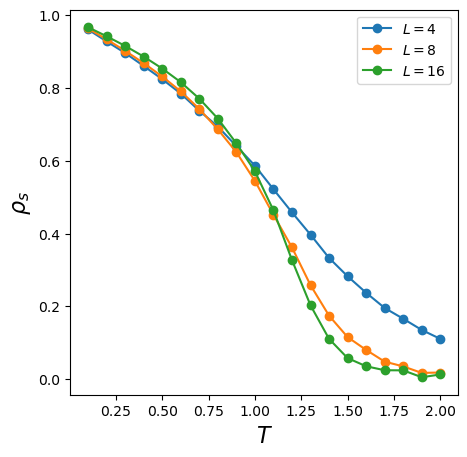

In [607]:
fig,ax = subplots(figsize=(5,5))

for i =1:length(Ns)
    L = Int(sqrt(Ns[i]))
    ax.plot(Ts,rhos[i,:],"-o",label=L"$L=$"*string(L))
end
ax.set_xlabel(L"$T$",fontsize=16)
ax.set_ylabel(L"$\rho_s$",fontsize=16)
ax.legend()
gcf()

We can see, that indeed as $T$ approaches $0$, the spin stiffness approaches $1$, and as $T\rightarrow\infty$, the spin stiffness decays to $0$.

## 5
*To obtain $T_{KT}$ we will follow the procedure used in Ref. [Phys. Rev. B 37, 5986(R) (1988)]. From the RG analysis of the KT transition, it is known that as $T \rightarrow T_{KT}$*

$$\rho_s(L) = \rho_s^\infty \left( 1 + \frac{1}{2} \frac{1}{\log(L)+C}\right)\;,$$

*where $\rho_s^\infty=2T_{KT}/\pi$ is the jump in the spin stiffness in at the transition point in the thermodynamic limit, and $C$ is an undetermined constant. Consider temperatures close to the phase transition (e.g. in the range $T=0.8$ to $1.0$) and for each temperature obtain $\rho_s(L)$ for systems of size $L = 4, 6, 8, 10$. Try to fit $\rho_s(L)$ you obtained to the form*

$$\rho_s(L) = \frac{2}{\pi} T \left( 1 + \frac{1}{2} \frac{1}{\log(L)+C}\right)\;.$$

*Note that for a given temperature the only free parameter in the fit is $C$. Denoting the standard deviation of the fit by $\Delta(T)$ look for the temperature $T$ for which $\Delta(T)$ is minimal. Since we expect this scaling to hold exactly at $T = T_{KT}$, i.e. for $\Delta(T_{KT})$ to vanish (at least once large enough system sizes are considered so that the RG analysis holds), obtaining the temperature at which $\Delta(T)$ is minimal will give us a (surprisingly good, given the system size we used) estimate of $T_{KT}$.*

In [609]:
using ProgressBars

In [654]:
Ls = 4:2:10
Ts = 0.8:0.01:1.0

rhos = zeros(length(Ts),length(Ls))
Nsw = Int(4e5)

for i in ProgressBar(1:length(Ts))
    for j = 1:length(Ls)
        lat = SquareLattice(Ls[j],Ls[j])
        @time En, Ix2, Iy2, config = XY_MC(lat, Ts[i], Nsw,Neq=Int(1e4))
        rhos[i,j] = - (En + (Ix2 + Iy2)/Ts[i])/(2*length(lat))
    end
end

0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]


  3.007059 seconds (27.00 M allocations: 2.391 GiB, 11.34% gc time)


  6.292417 seconds (54.59 M allocations: 5.089 GiB, 11.79% gc time)


 11.033886 seconds (93.01 M allocations: 8.881 GiB, 11.71% gc time)


 17.081247 seconds (141.96 M allocations: 13.470 GiB, 11.71% gc time)


4.8%┣██                                         ┫ 1/21 [00:37<Inf:Inf, InfGs/it]


  3.032942 seconds (26.97 M allocations: 2.386 GiB, 11.63% gc time)


  6.403526 seconds (54.51 M allocations: 5.076 GiB, 11.97% gc time)


 10.929469 seconds (92.85 M allocations: 8.858 GiB, 12.40% gc time)


 17.291707 seconds (141.67 M allocations: 13.423 GiB, 11.93% gc time)


9.5%┣████▌                                          ┫ 2/21 [01:15<23:47, 75s/it]


  2.993305 seconds (26.96 M allocations: 2.384 GiB, 12.18% gc time)


  6.684496 seconds (54.47 M allocations: 5.069 GiB, 12.21% gc time)


 10.281104 seconds (92.72 M allocations: 8.839 GiB, 12.99% gc time)


 16.414352 seconds (141.55 M allocations: 13.397 GiB, 12.59% gc time)


14.3%┣██████▋                                       ┫ 3/21 [01:52<16:44, 56s/it]


  3.067625 seconds (26.93 M allocations: 2.380 GiB, 12.36% gc time)


  6.308254 seconds (54.37 M allocations: 5.054 GiB, 12.65% gc time)


 11.131952 seconds (92.59 M allocations: 8.820 GiB, 13.24% gc time)


 16.846386 seconds (141.27 M allocations: 13.351 GiB, 12.65% gc time)


19.0%┣████████▊                                     ┫ 4/21 [02:29<14:04, 50s/it]


  3.230337 seconds (26.89 M allocations: 2.375 GiB, 19.69% gc time)


  6.392941 seconds (54.32 M allocations: 5.046 GiB, 10.36% gc time)


 10.786327 seconds (92.46 M allocations: 8.801 GiB, 10.78% gc time)


 15.622785 seconds (141.04 M allocations: 13.314 GiB, 11.13% gc time)


23.8%┣███████████                                   ┫ 5/21 [03:05<12:20, 46s/it]


  2.758062 seconds (26.87 M allocations: 2.372 GiB, 10.83% gc time)


  6.219057 seconds (54.23 M allocations: 5.033 GiB, 11.39% gc time)


 10.370564 seconds (92.30 M allocations: 8.778 GiB, 11.72% gc time)


 16.725854 seconds (140.90 M allocations: 13.289 GiB, 12.10% gc time)


28.6%┣█████████████▏                                ┫ 6/21 [03:41<11:03, 44s/it]


  3.047296 seconds (26.85 M allocations: 2.369 GiB, 11.58% gc time)


  6.118531 seconds (54.17 M allocations: 5.023 GiB, 11.59% gc time)


 10.903562 seconds (92.18 M allocations: 8.761 GiB, 12.13% gc time)


 16.820494 seconds (140.67 M allocations: 13.253 GiB, 12.09% gc time)


33.3%┣███████████████▍                              ┫ 7/21 [04:18<10:02, 43s/it]


  3.041418 seconds (26.82 M allocations: 2.364 GiB, 11.65% gc time)


  6.281544 seconds (54.11 M allocations: 5.012 GiB, 11.86% gc time)


 10.888564 seconds (92.12 M allocations: 8.752 GiB, 12.71% gc time)


 16.859066 seconds (140.45 M allocations: 13.220 GiB, 12.38% gc time)


38.1%┣█████████████████▌                            ┫ 8/21 [04:55<09:08, 42s/it]


  3.240327 seconds (26.79 M allocations: 2.360 GiB, 10.86% gc time)


  6.240911 seconds (54.02 M allocations: 4.998 GiB, 12.78% gc time)


 11.137271 seconds (91.89 M allocations: 8.719 GiB, 12.56% gc time)


 16.892079 seconds (140.25 M allocations: 13.189 GiB, 12.74% gc time)


42.9%┣███████████████████▊                          ┫ 9/21 [05:32<08:19, 42s/it]


  2.889692 seconds (26.75 M allocations: 2.356 GiB, 12.31% gc time)


  6.070647 seconds (53.95 M allocations: 4.987 GiB, 12.89% gc time)


 10.494384 seconds (91.76 M allocations: 8.700 GiB, 13.66% gc time)


 15.626312 seconds (139.96 M allocations: 13.146 GiB, 10.66% gc time)


47.6%┣█████████████████████▍                       ┫ 10/21 [06:08<07:29, 41s/it]


  2.853202 seconds (26.74 M allocations: 2.354 GiB, 10.60% gc time)


  5.894402 seconds (53.89 M allocations: 4.977 GiB, 10.90% gc time)


 10.250904 seconds (91.66 M allocations: 8.685 GiB, 11.49% gc time)


 15.769775 seconds (139.75 M allocations: 13.117 GiB, 11.37% gc time)


52.4%┣███████████████████████▋                     ┫ 11/21 [06:42<06:42, 40s/it]


  2.877328 seconds (26.71 M allocations: 2.350 GiB, 11.40% gc time)


  5.941698 seconds (53.82 M allocations: 4.967 GiB, 11.31% gc time)


 10.354436 seconds (91.54 M allocations: 8.667 GiB, 12.02% gc time)


 15.859219 seconds (139.57 M allocations: 13.091 GiB, 12.05% gc time)


57.1%┣█████████████████████████▊                   ┫ 12/21 [07:17<05:58, 40s/it]


  2.880706 seconds (26.68 M allocations: 2.347 GiB, 11.67% gc time)


  5.955311 seconds (53.71 M allocations: 4.950 GiB, 11.80% gc time)


 10.324521 seconds (91.35 M allocations: 8.639 GiB, 12.54% gc time)


 15.845648 seconds (139.32 M allocations: 13.056 GiB, 12.26% gc time)


61.9%┣███████████████████████████▉                 ┫ 13/21 [07:52<05:15, 39s/it]


  2.888748 seconds (26.65 M allocations: 2.343 GiB, 11.90% gc time)


  5.995437 seconds (53.67 M allocations: 4.943 GiB, 12.51% gc time)


 10.333691 seconds (91.21 M allocations: 8.618 GiB, 12.69% gc time)


 15.858541 seconds (139.08 M allocations: 13.022 GiB, 12.73% gc time)


66.7%┣██████████████████████████████               ┫ 14/21 [08:27<04:33, 39s/it]


  2.889437 seconds (26.63 M allocations: 2.340 GiB, 11.73% gc time)


  6.001949 seconds (53.59 M allocations: 4.930 GiB, 12.68% gc time)


 10.348161 seconds (91.10 M allocations: 8.602 GiB, 12.94% gc time)


 15.879099 seconds (138.82 M allocations: 12.987 GiB, 12.84% gc time)


71.4%┣████████████████████████████████▏            ┫ 15/21 [09:03<03:53, 39s/it]


  3.181549 seconds (26.60 M allocations: 2.336 GiB, 19.77% gc time)


  5.816563 seconds (53.51 M allocations: 4.917 GiB, 10.49% gc time)


 10.063539 seconds (90.95 M allocations: 8.579 GiB, 11.00% gc time)


 15.773996 seconds (138.65 M allocations: 12.965 GiB, 11.21% gc time)


76.2%┣██████████████████████████████████▎          ┫ 16/21 [09:37<03:12, 38s/it]


  2.875782 seconds (26.56 M allocations: 2.331 GiB, 10.67% gc time)


  5.872331 seconds (53.45 M allocations: 4.908 GiB, 11.20% gc time)


 10.084359 seconds (90.81 M allocations: 8.559 GiB, 11.79% gc time)


 15.459566 seconds (138.39 M allocations: 12.930 GiB, 11.86% gc time)


81.0%┣████████████████████████████████████▍        ┫ 17/21 [10:12<02:33, 38s/it]


  2.834240 seconds (26.53 M allocations: 2.328 GiB, 11.29% gc time)


  5.842492 seconds (53.35 M allocations: 4.892 GiB, 11.75% gc time)


 10.130150 seconds (90.65 M allocations: 8.536 GiB, 12.44% gc time)


 15.487542 seconds (138.13 M allocations: 12.895 GiB, 12.23% gc time)


85.7%┣██████████████████████████████████████▋      ┫ 18/21 [10:46<01:54, 38s/it]


  2.855621 seconds (26.51 M allocations: 2.324 GiB, 11.66% gc time)


  5.892450 seconds (53.26 M allocations: 4.879 GiB, 12.11% gc time)


 10.296946 seconds (90.49 M allocations: 8.512 GiB, 12.60% gc time)


 15.531132 seconds (137.91 M allocations: 12.866 GiB, 12.59% gc time)


90.5%┣████████████████████████████████████████▊    ┫ 19/21 [11:21<01:16, 38s/it]


  2.953778 seconds (26.49 M allocations: 2.322 GiB, 11.72% gc time)


  5.888287 seconds (53.20 M allocations: 4.868 GiB, 12.70% gc time)


 10.113812 seconds (90.36 M allocations: 8.492 GiB, 12.78% gc time)


 15.449900 seconds (137.66 M allocations: 12.833 GiB, 12.99% gc time)


95.2%┣██████████████████████████████████████████▉  ┫ 20/21 [11:55<00:38, 38s/it]


  2.886184 seconds (26.46 M allocations: 2.318 GiB, 12.32% gc time)


  5.893192 seconds (53.12 M allocations: 4.855 GiB, 12.79% gc time)


 10.151872 seconds (90.18 M allocations: 8.466 GiB, 13.79% gc time)


 15.190132 seconds (137.42 M allocations: 12.802 GiB, 10.91% gc time)


100.0%┣████████████████████████████████████████████┫ 21/21 [12:29<00:00, 37s/it]
100.0%┣████████████████████████████████████████████┫ 21/21 [12:29<00:00, 37s/it]


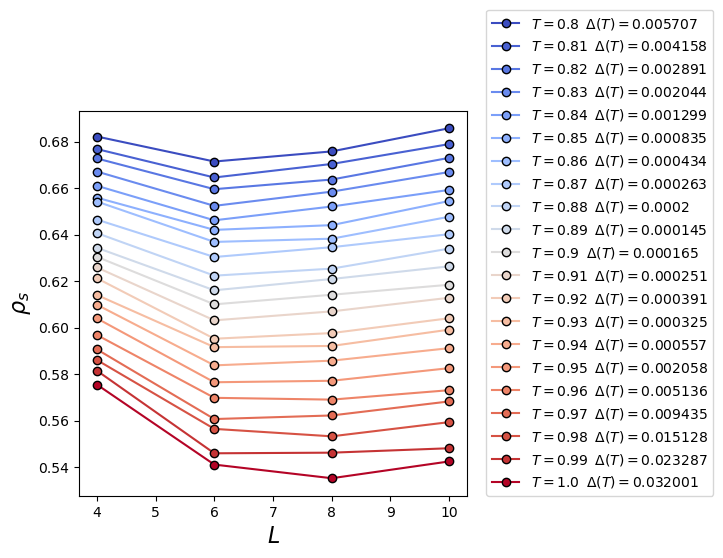

In [655]:
fig,ax = subplots(figsize=(5,5))

delta = []
for i =1:length(Ts)
    f(x,p) = 2 .* Ts[i] .* (1 .+ 0.5 ./ (log.(x) .+ p[1])) ./ pi 
    fit1 = curve_fit(f, convert(Vector{Float64},Ls), rhos[i,:],[0.])
    append!(delta, sum(fit1.resid.^2))
    color_index = (i-1) / (length(Ts)-1)
    ax.plot(Ls,rhos[i,:], "-o",
    label=L"$T=$"*string(Ts[i])*L"$\;\; \Delta(T)=$"*string(round(delta[i],digits=6)), 
    color=cmap(color_index),markeredgecolor="black")
end
# ax.scatter(Ls,rhos[11,:])
ax.set_xlabel(L"$L$",fontsize=16)
ax.set_ylabel(L"$\rho_s$",fontsize=16)
ax.legend(loc=(1.05,0.0))
gcf()

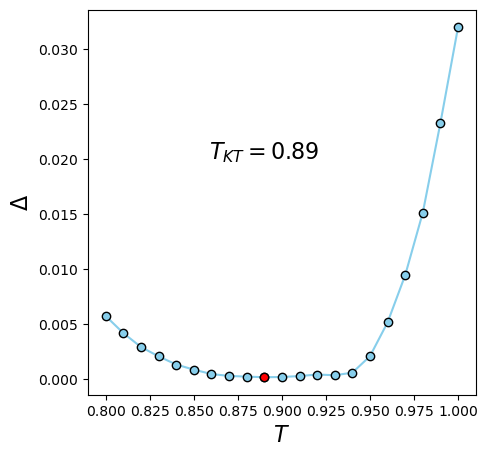

In [663]:
fig,ax = subplots(figsize=(5,5))

ax.plot(Ts,delta,"-o",color="skyblue", markeredgecolor="black")
ax.scatter(Ts[argmin(delta)],minimum(delta),color="red",edgecolor="black",zorder=2)

ax.text(Ts[argmin(delta)], 0.02,L"$T_{KT}=$"*string(Ts[argmin(delta)]),
horizontalalignment="center",fontsize=16)
ax.set_ylabel(L"$\Delta$",fontsize=16)
ax.set_xlabel(L"$T$",fontsize=16)
gcf()